## Expedia Hotel Recommendation 

Expedia uses search parameters to adjust their hotel recommendations, but there aren't enough customer specific data to personalize them for each user. In this competition, Expedia is challenging Kagglers to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

### Loading packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle
from sklearn.externals import joblib

from scipy.sparse.linalg import svds

from heapq import nlargest 
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns

import math
from functools import reduce

from time import localtime, strftime

### Reading Train Data
File has 37,670,293 records. To reduce amount of RAM used I specified dtype for each variable

In [2]:
print("Reading Train Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
train = pd.read_csv('data/train.csv.gz', 
    compression='gzip',
    # nrows =5000000,
    dtype={
    'user_id': np.int32, 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16, 
    'is_booking': np.int8, 
    'cnt': np.int64, 
    'hotel_cluster': np.int16},
    )
print("Reading Train Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

Reading Train Data... Started at 2018-02-02 23:31:07
Reading Train Data finished at 2018-02-02 23:32:35
 


In [3]:
train.head(n=10)

date_time  site_name  posa_continent  user_location_country  \
0  2014-08-11 07:46:59          2               3                     66   
1  2014-08-11 08:22:12          2               3                     66   
2  2014-08-11 08:24:33          2               3                     66   
3  2014-08-09 18:05:16          2               3                     66   
4  2014-08-09 18:08:18          2               3                     66   
5  2014-08-09 18:13:12          2               3                     66   
6  2014-07-16 09:42:23          2               3                     66   
7  2014-07-16 09:45:48          2               3                     66   
8  2014-07-16 09:52:11          2               3                     66   
9  2014-07-16 09:55:24          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                2234.264160   
1                   348               48862                2234.264160   
2                   348               48862                2234.264160   
3                   442               35390                 913.193176   
4                   442               35390                 913.625916   
5                   442               35390                 911.514221   
6                   189               10067                        NaN   
7                   189               10067                        NaN   
8                   189               10067                        NaN   
9                   189               10067                        NaN   

   user_id  is_mobile  is_package      ...        srch_children_cnt  \
0       12          0           1      ...                        0   
1       12          0           1      ...                        0   
2       12          0           0      ...                        0   
3       93          0           0      ...                        0   
4       93          0           0      ...                        0   
5       93          0           0      ...                        0   
6      501          0           0      ...                        0   
7      501          0           1      ...                        0   
8      501          0           0      ...                        0   
9      501          0           0      ...                        0   

  srch_rm_cnt srch_destination_id  srch_destination_type_id  is_booking  cnt  \
0           1                8250                         1           0    3   
1           1                8250                         1           1    1   
2           1                8250                         1           0    1   
3           1               14984                         1           0    1   
4           1               14984                         1           0    1   
5           1               14984                         1           0    1   
6           1                8267                         1           0    2   
7           1                8267                         1           0    1   
8           1                8267                         1           0    1   
9           1                8267                         1           0    1   

   hotel_continent  hotel_country  hotel_market  hotel_cluster  
0                2             50           628              1  
1                2             50           628              1  
2                2             50           628              1  
3                2             50          1457             80  
4                2             50          1457             21  
5                2             50          1457             92  
6                2             50           675             41  
7                2             50           675             41  
8                2             50           675             69  
9                2             50           675 

Variable *orig_destination_distance* has missing values. To impute missings was used 4 level imputation:
* Median value for each pair of values *user_location_city* and *hotel_market*
* Median value for each pair of values *user_location_region* and *hotel_market* 
* Median value for each pair of values *user_location_country* and *hotel_country*
* Median value

In [3]:
# Missing imputation for 'orig_destination_distance'
keys_for_mi = (['user_location_city', 'hotel_market'], ['user_location_region', 'hotel_market'], ['user_location_country', 'hotel_country'])
dist_imputer = []
median = train["orig_destination_distance"].median()
for keys in keys_for_mi:
    grouping_imputer = train.groupby(keys)["orig_destination_distance"].transform("median")
    train["orig_destination_distance"].fillna(grouping_imputer, inplace=True)
    dist_imputer.append(grouping_imputer)  


train["orig_destination_distance"].fillna(median, inplace=True)
dist_imputer.append(median)
print(train[train["orig_destination_distance"].notnull()].shape[0])


37670293


## Reading destinations file
To reduce memory usage was used not default dtype

In [4]:
dtype_dest = {}
for i in range(149):
    dtype_dest['d'+str(i+1)] = np.float32
dest = pd.read_csv('data/destinations.csv.gz', compression='gzip', dtype=dtype_dest, index_col='srch_destination_id')
scaler = StandardScaler()
dest = pd.DataFrame(data=scaler.fit_transform(dest.values), columns=dtype_dest.keys(), index=dest.index).reset_index()

## Reading Test Data
To reduce amount of RAM used I specified dtype for each variable same as for Train Data Set

In [5]:
print("Reading Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    )
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

Reading Data... Started at 2018-01-24 10:00:06
Reading Test Data finished at 2018-01-24 10:00:12
 


Overview of downloaded Data Frames

In [6]:
print(train.shape)
print(test.shape)
print(dest.shape)

(37670293, 24)
(2528243, 22)
(62106, 150)


In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37670293 entries, 0 to 37670292
Data columns (total 24 columns):
date_time                    object
site_name                    int16
posa_continent               int16
user_location_country        int16
user_location_region         int16
user_location_city           int32
orig_destination_distance    float32
user_id                      int32
is_mobile                    int8
is_package                   int16
channel                      int16
srch_ci                      object
srch_co                      object
srch_adults_cnt              int16
srch_children_cnt            int16
srch_rm_cnt                  int16
srch_destination_id          int32
srch_destination_type_id     int16
is_booking                   int8
cnt                          int64
hotel_continent              int16
hotel_country                int16
hotel_market                 int16
hotel_cluster                int16
dtypes: float32(1), int16(14), int32(3), i

In [8]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528243 entries, 0 to 2528242
Data columns (total 22 columns):
id                           int64
date_time                    object
site_name                    int16
posa_continent               int16
user_location_country        int16
user_location_region         int16
user_location_city           int32
orig_destination_distance    float32
user_id                      int32
is_mobile                    int8
is_package                   int16
channel                      int16
srch_ci                      object
srch_co                      object
srch_adults_cnt              int16
srch_children_cnt            int16
srch_rm_cnt                  int16
srch_destination_id          int32
srch_destination_type_id     int16
hotel_continent              int16
hotel_country                int16
hotel_market                 int16
dtypes: float32(1), int16(13), int32(3), int64(1), int8(1), object(3)
memory usage: 180.8+ MB
None


In [9]:
print(dest.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62106 entries, 0 to 62105
Columns: 150 entries, srch_destination_id to d149
dtypes: float32(149), int64(1)
memory usage: 35.8 MB
None


## Data exploration
Let's plot Expedia PoS frequency

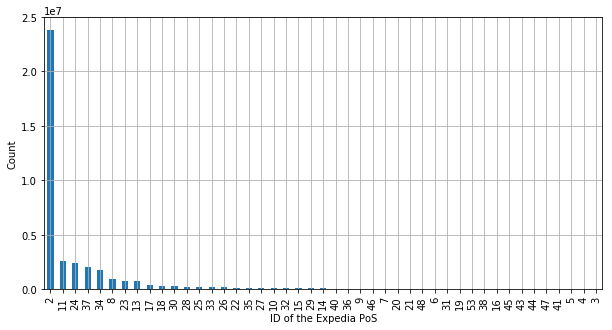

In [7]:
ax = train['site_name'].value_counts().plot(kind='bar', figsize=(10,5))
ax.set_ylabel('Count')
ax.set_xlabel('ID of the Expedia PoS')
plt.grid()
plt.show()

From the plot We can see that most popular is PoS #2 and other have low usage. 

On the next plot there is count for continent associated with site_name

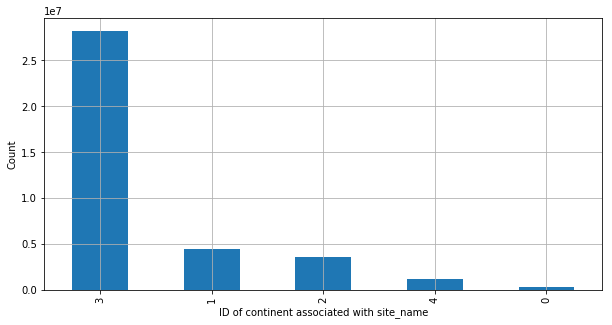

In [8]:
ax = train['posa_continent'].value_counts().plot(kind='bar', figsize=(10,5))
ax.set_ylabel('Count')
ax.set_xlabel('ID of continent associated with site_name')
plt.grid()
plt.show()

Third continent is a leader provider of users

Distribution plot by Hotel Market

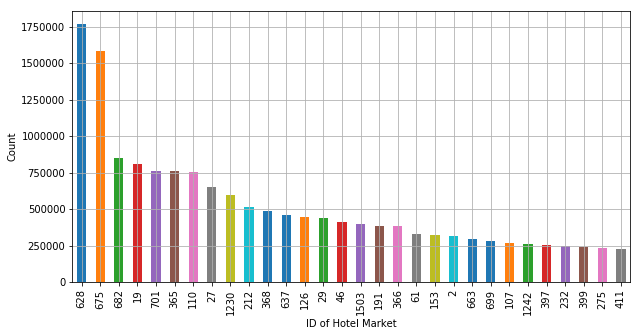

In [11]:
ax = train['hotel_market'].value_counts()[:30].plot(kind='bar', figsize=(10,5))
ax.set_ylabel('Count')
ax.set_xlabel('ID of Hotel Market')
plt.grid()
plt.show()

Hotel markets 628 and 675 are searsh leaders.

Plot of distribution by channel

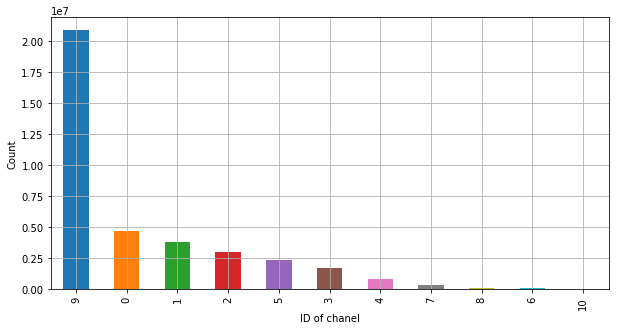

In [12]:
ax = train['channel'].value_counts().plot(kind='bar', figsize=(10,5))
ax.set_ylabel('Count')
ax.set_xlabel('ID of chanel')
plt.grid()
plt.show()

Let's plot our target variable distribution

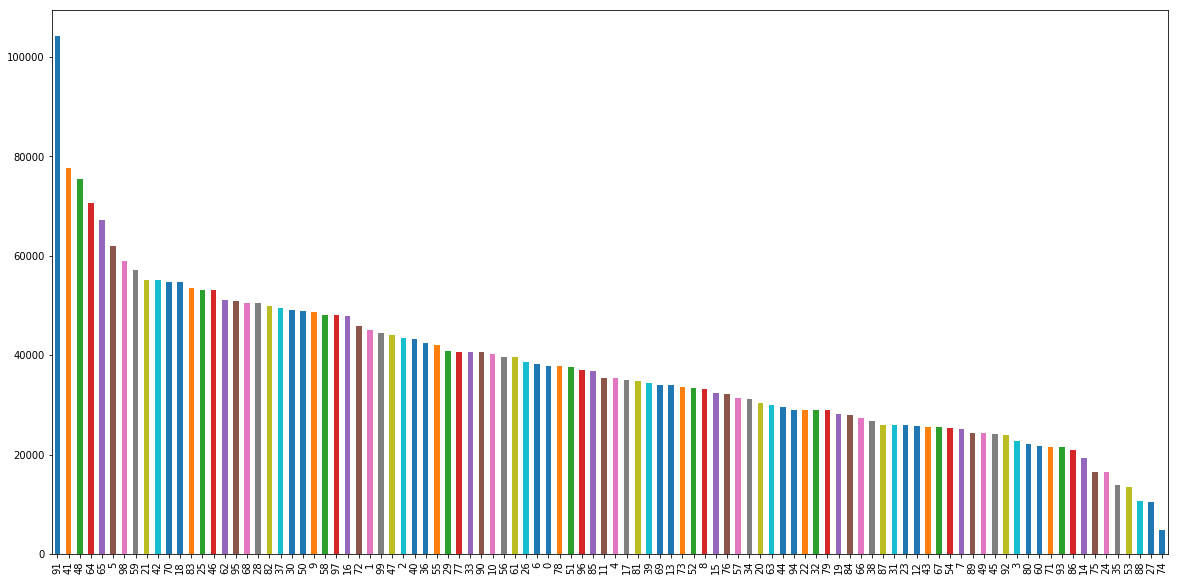

In [3]:
train['hotel_cluster'].value_counts().plot(kind='bar', figsize=(20,10))
plt.show()

Most popular predicted hotel clusters predicted by Expedia are 91, 41, 48, 64 and 65. We can use this information in future and to build our baseline prediction.

Now we will plot how far people are planning to go from their continent.

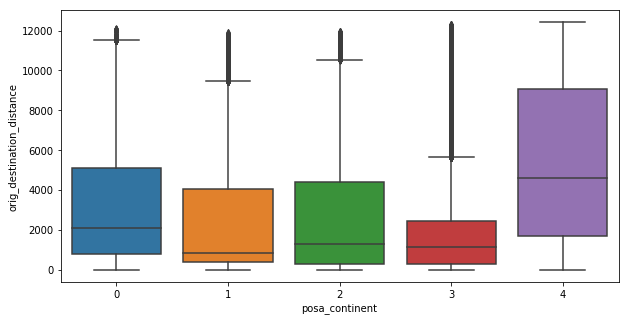

In [15]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='posa_continent', y='orig_destination_distance', data=train)
plt.show()

This shows that people from third continent are using Expedia the most but average traveling distance is second lowest. Most distant travelers came from continent 4.

Next plot shows how far top 30 countries users whant to travel.

C:\Users\Kyryl Ielizarov\AppData\Local\conda\conda\envs\Kaggle\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


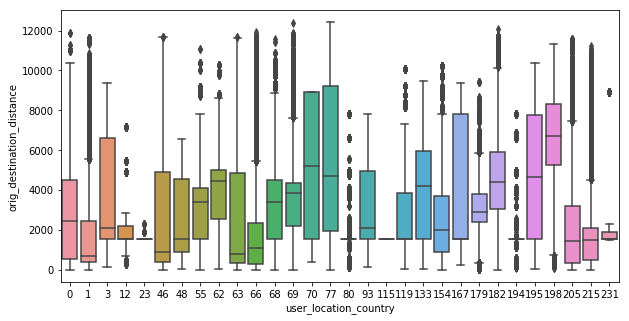

In [15]:
top_user_countries = train['user_location_country'].value_counts()[:30]
plt.figure(figsize=(10, 5))
ax = sns.boxplot(x='user_location_country', y='orig_destination_distance', data=train[train['user_location_country'].isin(top_user_countries.index.values)])
plt.show()

Users from country 198 in average cover the bigest distance but users from countries 70 and 77 have one of the widest traveking preferences.

On the next plot we will se how far people would like to travel for top 50 hotel cluster.

C:\Users\Kyryl Ielizarov\AppData\Local\conda\conda\envs\Kaggle\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


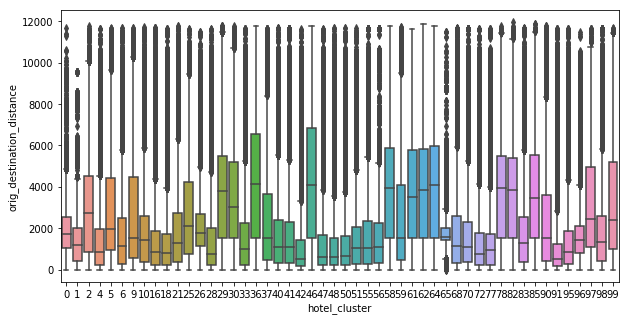

In [16]:
top_hotel_cluster = train['hotel_cluster'].value_counts()[:50]
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x='hotel_cluster', y='orig_destination_distance', data=train[train['hotel_cluster'].isin(top_hotel_cluster.index.values)])
plt.show()

It shows that most popular clusters are not so distant from users, usually less 2000 km and could be with in US.

Let's create a Most frequent submission.

In [ ]:
# base submission top 5 freq, score=0.05949
test_submission = pd.DataFrame(data=test['id'], columns=['id'])
test_submission['hotel_cluster'] = '91 41 48 64 65'
test_submission.to_csv('submissions/base_submission.csv', index=False)

This submission has score 0.05949 and will be our baseline for other predictions.

## Data preparation
We need to calculate booking ration to undestand the percentage of users which made booking raser that just search

In [5]:
print(train['is_booking'].value_counts())
non_booking_cnt = train['is_booking'].value_counts()[0]
booking_cnt = train['is_booking'].value_counts()[1]
booking_ratio = round(booking_cnt/non_booking_cnt, 5)
print(booking_ratio)

0    34669600
1     3000693
Name: is_booking, dtype: int64
0.08655


Only 3,000,693 or 8.65% of searches ended by bookings.

Also we need to calculate hotel cluster weight to boost our model and create a 10% sample for training of One Hot Ecoder and Standard Scaler

In [6]:
class_values = np.unique(train['hotel_cluster'].values)
class_weight = compute_class_weight(class_weight='balanced', classes=class_values, y=train['hotel_cluster'].values)
if train.shape[0] > 2000000:
    train = train.sample(frac=0.1, random_state=25)


We build a function which will prepare our datasets by sending list of variables used for modeling, distance imputer, ecoder for class variables and list of class variables and scaled destinations file.

In [7]:
def data_transform(df_x, class_vars, encoder, scaler, dist_imputer, dest, model_vars):
    df_x = df_x[model_vars+['srch_destination_id']]
    # df_x = df_x.drop(['site_name', 'posa_continent', 'date_time', 'srch_ci', 'srch_co'], axis=1)
    df_x = df_x.merge(dest, how='left', on='srch_destination_id', right_index=True)
    df_x = df_x.drop(['srch_destination_id'], axis=1)
    for grouping_imputer in dist_imputer:  
        df_x["orig_destination_distance"].fillna(grouping_imputer, inplace=True)

    df_x["orig_destination_distance"] = scaler.transform(df_x[["orig_destination_distance"]].values)
    df_x=df_x.dropna(axis=1)
    encoded = encoder.transform(df_x[class_vars].values)
    other = df_x.drop(class_vars, axis=1).values
    X = np.concatenate((encoded, other), axis=1)
    return X

def five_max(a):
    return a.argsort()[-5:][::-1]


In this section we train Standard Scaler, One Hot Encoder modules and create a validation set for verifing or model.

In [8]:
# Class variables
model_vars = ['user_location_country', 'orig_destination_distance',
        'srch_adults_cnt', 'is_package', 'is_mobile',
       'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_type_id', 'hotel_country']
class_vars = ['user_location_country',  'srch_destination_type_id', 
       'hotel_country']


var_list = train.drop(['hotel_cluster'], axis=1).columns.values

class_mask = [(i in class_vars) for i in var_list]
print(list(zip(class_mask, var_list)))

#Fit encoder 
print("Fitting Encoder... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))   
encoder = OneHotEncoder(dtype=np.int8, sparse=False, handle_unknown='ignore')
encoder.fit(train[class_vars].values)

#Fit scaler 
print("Fitting Standard Scaler... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))  
scaler = StandardScaler()
scaler.fit(train[['orig_destination_distance']].values)

print("Creating validation set. Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
valid = train.sample(n=200000, random_state=25)

y_valid = valid['hotel_cluster'].values

X_valid = data_transform(valid, class_vars, encoder, scaler, dist_imputer, dest, model_vars)

valid_index = valid.index

del train
del valid

[(False, 'date_time'), (False, 'site_name'), (False, 'posa_continent'), (True, 'user_location_country'), (False, 'user_location_region'), (False, 'user_location_city'), (False, 'orig_destination_distance'), (False, 'user_id'), (False, 'is_mobile'), (False, 'is_package'), (False, 'channel'), (False, 'srch_ci'), (False, 'srch_co'), (False, 'srch_adults_cnt'), (False, 'srch_children_cnt'), (False, 'srch_rm_cnt'), (False, 'srch_destination_id'), (True, 'srch_destination_type_id'), (False, 'is_booking'), (False, 'cnt'), (False, 'hotel_continent'), (True, 'hotel_country'), (False, 'hotel_market')]
Fitting Encoder... Started at 2018-01-24 10:44:24
Fitting Standard Scaler... Started at 2018-01-24 10:44:25
Creating validation set. Started at 2018-01-24 10:44:25


## Modeling using SGD classifier
For modeling I used SGDClassifier for scikit-learn package. It was used because of it can be trained on chunks of big dataset we have.

Our dataset is loaded by chunks of size 200,000. Each subset is transformed using built function and made a partial fit. Training process run 2 times(epochs, could be adjusted) over all data set.
On each ten chunks we calculate model accuracy on validation set and save model to file, so we don't lose the results in case of some power downs.

In [15]:
clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.0001, random_state=19, max_iter=5,
                    learning_rate='optimal', l1_ratio=0.4,
                    class_weight=dict(zip(class_values, class_weight)), warm_start=True, n_jobs=-1)
list_accuracy = []
epochs = 2
for i in range(epochs):
    chunk_num = 1
    print("*** Started working with epoch #{0} at {1} ***".format(i+1, strftime("%Y-%m-%d %H:%M:%S", localtime())))
    chunk_size = 200000

    train_reader = pd.read_csv('data/train.csv.gz', 
        compression='gzip',
        chunksize =chunk_size,
        dtype={
        'user_id': np.int32, 
        'site_name': np.int16, 
        'posa_continent': np.int16, 
        'user_location_country': np.int16, 
        'user_location_region': np.int16, 
        'user_location_city': np.int32, 
        'orig_destination_distance': np.float32, 
        'is_mobile': np.int8, 
        'is_package': np.int16, 
        'channel': np.int16, 
        'srch_adults_cnt': np.int16, 
        'srch_children_cnt': np.int16, 
        'srch_rm_cnt': np.int16, 
        'srch_destination_id': np.int32, 
        'srch_destination_type_id': np.int16, 
        'hotel_continent': np.int16, 
        'hotel_country': np.int16, 
        'hotel_market': np.int16, 
        'is_booking': np.int8, 
        'cnt': np.int64, 
        'hotel_cluster': np.int16},
        )
    for chunk in train_reader:
        if chunk_num % 10 == 0:
            print("Started working with chunk #{0}, epoch #{2} at {1}".format(chunk_num, strftime("%Y-%m-%d %H:%M:%S", localtime()), i+1))
            print((chunk_size*(chunk_num-1), chunk_size*chunk_num))
        chunk = shuffle(chunk)
        chunk = chunk.loc[~chunk.index.isin(valid_index)]
        chunk_weight = chunk['is_booking'].apply(lambda x: x if x==1 else booking_ratio*7).values
        chunk = chunk.drop(['user_id', 'is_booking', 'cnt'], axis=1)
        y_train = chunk['hotel_cluster'].values
        chunk = chunk.drop(['hotel_cluster'], axis=1)
        X_train = data_transform(chunk, class_vars, encoder, scaler, dist_imputer, dest, model_vars)
        
        clf.partial_fit(X_train, y_train, classes=class_values, sample_weight=chunk_weight)
        chunk_num += 1
        list_accuracy.append(clf.score(X_valid, y_valid))
        if chunk_num % 10 == 0:
            print(X_train.shape)
            print("Accuracy: {}".format(clf.score(X_valid, y_valid)))
            #if chunk_num % 50 == 0:
                #y_pred = clf.predict(X_valid)
                #print(classification_report(y_valid, y_pred))
            joblib.dump(clf, 'sgdc_expedia_model.pkl')
        # proba = clf.predict_log_proba(X_valid)
        # pred_class = np.apply_along_axis(five_max, 1, proba)


*** Started working with epoch #1 at 2018-01-24 12:07:54 ***


KeyboardInterrupt: 

After training of model we load it from file to score on test dataset. Test file is also read in chunks of 100,000 records.

In [14]:
# Load model
clf = joblib.load('sgdc_expedia_model_l1_log07.pkl')
chunk_size = 100000
chunk_num = 1


test_reader = pd.read_csv('data/test.csv.gz',
    chunksize =chunk_size,
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    )
print("Scoring Test Data...  {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test_submission = pd.DataFrame()
for chunk in test_reader:
    test_submission_part = pd.DataFrame(data=chunk['id'], columns=['id'])
    chunk = chunk.drop(['user_id', 'id'], axis=1)
    X_test = data_transform(chunk, class_vars, encoder, scaler, dist_imputer, dest, model_vars)
    #print(X_test.shape)
    y_test = clf.predict(X_test)
    
    proba = clf.predict_proba(X_test)
    pred_class = np.apply_along_axis(five_max, 1, proba)
    #print(pred_class.shape)
    
    # test_submission_part['hotel_cluster'] = y_test
    test_submission_part['hotel_cluster'] = pred_class.tolist()
    test_submission_part['hotel_cluster'] = test_submission_part['hotel_cluster'].apply(lambda x: ' '.join([str(i) for i in x]))
    #test_submission_part['proba'] = np.round(proba.tolist(), 4)
    test_submission = test_submission.append(test_submission_part)
print("Scoring Test Data Finished at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime()))) 
    
test_submission.to_csv('submissions/sgdc_submission.csv', index=False)

Scoring Test Data...  2018-01-23 08:12:46
 
Scoring Test Data Finished at 2018-01-23 08:13:39


This model gives a score of around 0.11268. Now we will try to use another approaches.

## Four level frequency recommendations
This approaches based on recommending hotel clusters on search parameters of user. These are four levels of comparison:
1. *user_location_region* and *srch_destination_id*
2. *user_location_city* and *hotel_country*
3. *hotel_market*
4. Top 5 frequency clusters for cases which have not populated in previous steps

Next code creates dictionaries for first three steps. Each entrie is weighted if it was booking or not.


In [2]:
print("Reading Train Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
train = pd.read_csv('data/train.csv.gz', 
    compression='gzip',
    # nrows =5000000,
    dtype={
    'user_id': np.int32, 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16, 
    'is_booking': np.int8, 
    'cnt': np.int64, 
    'hotel_cluster': np.int16},
    usecols=['user_id', 'user_location_region', 'user_location_city', 'srch_destination_id', 'srch_destination_id', 'is_booking', 'hotel_country', 'hotel_market', 'hotel_cluster' ])
print("Reading Train Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

print(train['is_booking'].value_counts())
non_booking_cnt = train['is_booking'].value_counts()[0]
booking_cnt = train['is_booking'].value_counts()[1]
booking_ratio = booking_cnt/non_booking_cnt
print(booking_ratio)
print("First {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
# 
df_freq = train.groupby(['user_location_region', 'srch_destination_id',  'is_booking', 'hotel_cluster']).agg(
    {"user_id": len}).rename(columns={'user_id': 'count'}).reset_index()
df_freq['count'] = df_freq.apply(lambda x: x['count'] if x['is_booking'] == 1 else x['count']*booking_ratio*7, axis=1) 
df_freq = df_freq.groupby(['user_location_region', 'srch_destination_id', 'hotel_cluster']).agg({'count': 'sum'}).unstack(level='hotel_cluster')
count_ur_sd = df_freq['count'].to_dict('index')
del df_freq

print('First Finished')
print("Second {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
df_freq = train.groupby(['user_location_city', 'hotel_country',  'is_booking', 'hotel_cluster']).agg(
    {"user_id": len}).rename(columns={'user_id': 'count'}).reset_index()
df_freq['count'] = df_freq.apply(lambda x: x['count'] if x['is_booking'] == 1 else x['count']*booking_ratio*7, axis=1) 
df_freq = df_freq.groupby(['user_location_city', 'hotel_country', 'hotel_cluster']).agg({'count': 'sum'}).unstack(level='hotel_cluster')
count_ul_hc_hm = df_freq['count'].to_dict('index')
del df_freq

print('Second Finished')
print("Third {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
df_freq = train.groupby(['hotel_market',  'is_booking', 'hotel_cluster']).agg(
    {"user_id": len}).rename(columns={'user_id': 'count'}).reset_index()
df_freq['count'] = df_freq.apply(lambda x: x['count'] if x['is_booking'] == 1 else x['count']*booking_ratio*7, axis=1) 
df_freq = df_freq.groupby(['hotel_market', 'hotel_cluster']).agg({'count': 'sum'}).unstack(level='hotel_cluster')
count_hm = df_freq['count'].to_dict('index')
del df_freq

print('Third Finished')

Reading Train Data... Started at 2018-01-24 12:08:30
Reading Train Data finished at 2018-01-24 12:09:12
 
0    34669600
1     3000693
Name: is_booking, dtype: int64
0.0865511283661
First 2018-01-24 12:09:13
 
First Finished
Second 2018-01-24 12:12:17
 
Second Finished
Third 2018-01-24 12:14:39
 
Third Finished


In next step we recommend clusters based on build dictionaries. On aech step we append top five clusters in this group. In final sumbmission we choose first five hotel clusters and save it to final file.

In [4]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['id', 'user_location_region', 'user_location_city', 'srch_destination_id', 'srch_destination_id', 'hotel_country', 'hotel_market'])
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))


def suggest_cluster(row, cnt_ul_hc_hm, cnt_ur_sd, cnt_hm):
    n_large = ''
    n_large_list = []
    if row['id'] % 100000 == 0:
        print(row['id'])
    d1_key = (row['user_location_region'], row['srch_destination_id'])   
    d2_key = (row['user_location_city'], row['hotel_country'])
    d3_key = (row['hotel_market'])
    if d1_key in cnt_ur_sd:
        d = cnt_ur_sd[d1_key]
        n_large_list += [str(i[0]) for i in nlargest(5, d.items(), key=itemgetter(1)) if not math.isnan(i[1])]
    if d2_key in cnt_ul_hc_hm:
        d = cnt_ul_hc_hm[d2_key]
        n_large_list += [str(i[0]) for i in nlargest(5, d.items(), key=itemgetter(1)) if not math.isnan(i[1])]
    if d3_key in count_hm:
        d = cnt_hm[d3_key]
        n_large_list += [str(i[0]) for i in nlargest(5, d.items(), key=itemgetter(1)) if not math.isnan(i[1])]
    n_large_list += ['91', '41', '48', '64', '65']
    n_large = reduce(lambda l, x: l+[x] if x not in l else l, n_large_list, [])[:5]
    n_large = ' '.join(n_large)
    #if row['id'] % 100000 == 0:
        #print(n_large_list)
        #print(n_large)
    return n_large
test_submission = pd.DataFrame(data=test['id'], columns=['id'])
test_submission['hotel_cluster'] = test.apply(lambda x: suggest_cluster(x, count_ul_hc_hm, count_ur_sd, count_hm), axis=1)
test_submission.to_csv('submissions/freq_4lev_submission.csv', index=False)
print("Cluster suggestion finished. {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

Reading Test Data... Started at 2018-01-24 12:16:20
Reading Test Data finished at 2018-01-24 12:16:23
 
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
Cluster suggestion finished. 2018-01-24 12:20:18
 


## Recommender sytem based on Matrix Factorizations
Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.

We need do define some event strength for each user and hotel cluster interaction. In next code box you can see several variants of bulding such stregth evaluation functions

In [2]:
# score 0.05971
def event_strength(row):
    return row['is_booking']*row['cnt']

# score 0.06425
def event_strength(row):
    result = 0
    mult = 0
    if row['is_booking'] == 1:
        mult = 1
    else:
        mult = 5 * booking_ratio
    
    result = mult * (row['cnt'] + round(row['orig_destination_distance']/1000))
    return result

# score 0.09323
def event_strength(row):
    result = 0
    mult = 0
    if row['is_booking'] == 1:
        mult = 10
    else:
        mult = 1
    result = mult * row['cnt']
    return result

Building Matrix factorization is presented in the next code section block

In [3]:
print("Reading Train Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
train = pd.read_csv('data/train.csv.gz', 
    compression='gzip',
    #nrows =1000000,
    dtype={
    'user_id': np.int32, 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16, 
    'is_booking': np.int8, 
    'cnt': np.int64, 
    'hotel_cluster': np.int16},
    usecols=['user_id', 'is_booking', 'cnt', 'hotel_cluster', 'orig_destination_distance', 'user_location_city',
              'hotel_market', 'user_location_region','user_location_country', 'hotel_country']
    )
print("Reading Train Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

# Missing imputation for 'orig_destination_distance'
keys_for_mi = (['user_location_city', 'hotel_market'], ['user_location_region', 'hotel_market'], ['user_location_country', 'hotel_country'])
dist_imputer = []

for keys in keys_for_mi:
    grouping_imputer = train.groupby(keys)["orig_destination_distance"].transform("median")
    train["orig_destination_distance"].fillna(grouping_imputer, inplace=True)
    dist_imputer.append(grouping_imputer)  

median = train["orig_destination_distance"].median()
train["orig_destination_distance"].fillna(median, inplace=True)
dist_imputer.append(median)

non_booking_cnt = train['is_booking'].value_counts()[0]
booking_cnt = train['is_booking'].value_counts()[1]
booking_ratio = round(booking_cnt/non_booking_cnt, 5)
print(booking_ratio)


train_action = train[['user_id', 'is_booking', 'cnt', 'hotel_cluster', 'orig_destination_distance']]
del train

print("Creating event strength")
print("Creating Event Strength... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
# Apply event_strenght function to train data set
train_action['event_strength'] = train_action.apply(event_strength, axis=1)
print("Event Strength Created at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

# Group by each user and hotel cluster so we have unique pair of user and hotel cluster and event strength for them
train_action = train_action.groupby(['user_id', 'hotel_cluster'])['event_strength'].sum().reset_index()

#Creating a sparse pivot table with users in rows and hotel clusters in columns
train_action_pivot_df = train_action.pivot(index='user_id', 
                                           columns='hotel_cluster', 
                                           values='event_strength').fillna(0)

train_action_pivot_matrix = train_action_pivot_df.as_matrix()
print("Started SVD at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
#The number of factors to factor the user-hotel_cluster matrix.
NUMBER_OF_FACTORS_MF = 75
# Performs matrix factorization of the original user hotel cluster matrix
U, sigma, Vt = svds(train_action_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
print("Finished SVD at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
sigma = np.diag(sigma)

# Making predictions from decompossed matrix
all_user_predicted_strength = np.dot(np.dot(U, sigma), Vt) 

preds_df = pd.DataFrame(all_user_predicted_strength, columns=train_action_pivot_df.columns, index=train_action_pivot_df.index)





Reading Train Data... Started at 2018-01-24 12:20:52
Reading Train Data finished at 2018-01-24 12:21:39
 
0.08655
Creating event strength
Creating Event Strength... Started at 2018-01-24 12:21:55
Event Strength Created at 2018-01-24 12:30:57
Started SVD at 2018-01-24 12:31:13
Finished SVD at 2018-01-24 12:31:21


Next block has function which makes prediction for hotel cluster

In [4]:
def recommend_hotel(predictions_df, user_id, num_recommendations=5):
    # Get and sort the user's predictions
    
    if user_id in predictions_df.index:
        
        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations = predictions_df.loc[user_id].reset_index().sort_values(user_id, ascending=False).iloc[:num_recommendations, :-1]
        recommendations = recommendations['hotel_cluster'].values
    else:
        recommendations = [91, 41, 48, 64, 65]
    if user_id % 10000 == 0: 
        print((user_id, recommendations, strftime("%Y-%m-%d %H:%M:%S", localtime())))
        
    recommendations = ' '.join([str(i) for i in recommendations])
    return recommendations

Making predictions on test data

In [5]:
print("Reading Test Data... Started at {0}".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))
test = pd.read_csv('data/test.csv.gz',
    compression='gzip',
    # nrows = 1000000,
    dtype={ 
    'site_name': np.int16, 
    'posa_continent': np.int16, 
    'user_location_country': np.int16, 
    'user_location_region': np.int16, 
    'user_location_city': np.int32, 
    'orig_destination_distance': np.float32, 
    'user_id': np.int32, 
    'is_mobile': np.int8, 
    'is_package': np.int16, 
    'channel': np.int16, 
    'srch_adults_cnt': np.int16, 
    'srch_children_cnt': np.int16, 
    'srch_rm_cnt': np.int16, 
    'srch_destination_id': np.int32, 
    'srch_destination_type_id': np.int16, 
    'hotel_continent': np.int16, 
    'hotel_country': np.int16, 
    'hotel_market': np.int16}, 
    usecols=['id', 'user_id'])
print("Reading Test Data finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

test_submission = pd.DataFrame(data=test['id'], columns=['id'])
test_submission['hotel_cluster'] = test['user_id'].apply(lambda x: recommend_hotel(preds_df, x))
test_submission.to_csv('submissions/recommend_isbooking_submission.csv', index=False)
print("Scoring by Recommendation System is  finished at {0}\n ".format(strftime("%Y-%m-%d %H:%M:%S", localtime())))

Reading Test Data... Started at 2018-01-24 12:31:22
Reading Test Data finished at 2018-01-24 12:31:25
 
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(20000, array([69, 41, 70, 68, 98], dtype=int64), '2018-01-24 12:31:32')
(150000, array([25,  2, 98, 95,  9], dtype=int64), '2018-01-24 12:32:14')
(150000, array([25,  2, 98, 95,  9], dtype=int64), '2018-01-24 12:32:14')
(160000, array([70, 41,  2, 56, 34], dtype=int64), '2018-01-24 12:32:18')
(240000, array([54, 48, 82, 32, 62], dtype=int64), '2018-01-24 12:32:45')
(240000, array([54, 48, 82, 32, 62], dtype=int64), '2018-01-24 12:32:45')
(240000, array(

(810000, array([51,  8, 23, 76, 90], dtype=int64), '2018-01-24 12:55:54')
(920000, array([54, 48, 34, 91, 71], dtype=int64), '2018-01-24 12:56:31')
(920000, array([54, 48, 34, 91, 71], dtype=int64), '2018-01-24 12:56:31')
(920000, array([54, 48, 34, 91, 71], dtype=int64), '2018-01-24 12:56:31')
(1000000, array([ 4,  0, 49, 83, 17], dtype=int64), '2018-01-24 12:56:58')
(1020000, array([19, 45, 49, 24, 88], dtype=int64), '2018-01-24 12:57:05')
(1120000, array([65, 87, 31, 73, 80], dtype=int64), '2018-01-24 12:57:40')
(80000, array([50, 16, 11, 38, 75], dtype=int64), '2018-01-24 12:58:34')
(100000, array([37, 28, 22, 90, 41], dtype=int64), '2018-01-24 12:58:40')
(100000, array([37, 28, 22, 90, 41], dtype=int64), '2018-01-24 12:58:40')
(100000, array([37, 28, 22, 90, 41], dtype=int64), '2018-01-24 12:58:40')
(120000, array([ 8, 19, 35, 92, 49], dtype=int64), '2018-01-24 12:58:47')
(130000, array([94, 77, 10,  6, 48], dtype=int64), '2018-01-24 12:58:51')
(130000, array([94, 77, 10,  6, 48],

(910000, array([77, 23, 42, 71, 76], dtype=int64), '2018-01-24 13:16:32')
(950000, array([43, 79, 87, 31,  7], dtype=int64), '2018-01-24 13:16:44')
(990000, array([47,  5, 10, 70, 17], dtype=int64), '2018-01-24 13:16:58')
(1100000, array([83, 50, 72, 41, 17], dtype=int64), '2018-01-24 13:17:35')
(1100000, array([83, 50, 72, 41, 17], dtype=int64), '2018-01-24 13:17:35')
Scoring by Recommendation System is  finished at 2018-01-24 13:18:13
 


## Results
During analysis of Expedia Hotel Recommendations tasks were studied several approaches. 

### Top Frequency
Based on highest number of occurence of hotel cluster recomendations in train data. 
*Score 0,05949*

### Matrix Factorization Recommender System
Based on users and hotel cluster matrix Singular Value Decomposition
*Score 0,09223*
Way to improve: Develop such sytem which can take into consideration features of users and their search and hotels features. Add more advanced system for users which haven't used system previously

### Four Level Top Frequency
This recommendation is built on four level of features grouping and predicting top occured hotel clusters to users.
*Score 0,10078*
Way to improve: Consider more combinations of features or add more layers

### SGDClassifier
Built using log loss function a SGD Classifier.
*Score 0,11268*
Way to improve: Try ensembling and other non linear methods. Use cross validation for parameters tunning.

![Image of Submissions](https://kojkxa-db3pap001.files.1drv.com/y4mviFNhoRaondRyL7RAPelxRQlDAo7knazWdK6JbsdcnhNrSsSXeoSaYjznVW9Xl8d92yrPfZXQ9QP3C23G7Xu5RH5y3cTwU8PiRHhRDoDstNQ1OcKpBo9pN3Obk6ealSWvPKJEiCp32shsF_IqTxTTTlGYz1x7QNv0b69rfLdvl9H2s02Ry7U2FXQ4oAImzyfWQFoGxdR31tuWeSFIZnA2w?width=830&height=854&cropmode=none)